In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_df = pd.read_csv('/code/MyCode/AUG/HAM10000/train.csv')
test_df = pd.read_csv('/code/MyCode/AUG/HAM10000/test.csv')
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
train_path = '/code/MyCode/AUG/HAM10000/train_dir'
test_path = '/code/MyCode/AUG/HAM10000/test_dir'
batch_size=16

In [ ]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [ ]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 55115 images belonging to 7 classes.

Test Batches: 
Found 2003 images belonging to 7 classes.


In [ ]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [ ]:

irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output


In [ ]:

#SOFT ATTENTION
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)


In [ ]:
from tensorflow.keras import models
model.load_weights("/code/MyCode/AUG/Aug-Att/IRV2+SA.hdf5")
predictions_IRV2 = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

DENSENET

In [ ]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 55115 images belonging to 7 classes.

Test Batches: 
Found 2003 images belonging to 7 classes.


In [ ]:
densenet = tf.keras.applications.DenseNet201(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)
# Exclude the last 28 layers of the model.
conv = densenet.layers[-28].output

In [ ]:

#SOFT ATTENTION
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=densenet.input, outputs=output)

In [ ]:
from tensorflow.keras import models
model.load_weights("/code/MyCode/AUG/Aug-Att/Densenet201+SA.hdf5")
predictions_Densenet = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

resnet50

In [ ]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 55115 images belonging to 7 classes.

Test Batches: 
Found 2003 images belonging to 7 classes.


In [ ]:
resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-3].output

In [ ]:

attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


In [ ]:
from keras.layers import GlobalAveragePooling2D

output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)

In [ ]:
from tensorflow.keras import models
model.load_weights("/code/MyCode/AUG/Aug-Att/ResNet50+SA.hdf5")
predictions_Resnet50 = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

resnet34

In [ ]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 55115 images belonging to 7 classes.

Test Batches: 
Found 2003 images belonging to 7 classes.


In [ ]:
MainInput=Input(shape=(224, 224, 3))

In [ ]:
def convlayer1(input_value):
  conv1=Conv2D(filters=64, kernel_size=(3,3), strides=(2,2),activation="relu",padding="same")(input_value)
  conv1=BatchNormalization()(conv1)
  pool1=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
  return pool1

In [ ]:
def convlayer2(input_value):
  conv2=Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv2=BatchNormalization()(conv2)
  conv2=Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same")(conv2)
  conv2=BatchNormalization()(conv2)

  resnet=add([input_value,conv2])
  resnet=Activation("relu")(resnet)
  return resnet

In [ ]:
def convlayer3(input_value):
  conv3=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv3=BatchNormalization()(conv3)
  conv3=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(conv3)
  conv3=BatchNormalization()(conv3)


  skip=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv3])
  resnet=Activation("relu")(resnet)
  return resnet

In [ ]:
def convlayer4(input_value):
  conv4=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv4=BatchNormalization()(conv4)
  conv4=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(conv4)
  conv4=BatchNormalization()(conv4)


  skip=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv4])
  resnet=Activation("relu")(resnet)
  return resnet

In [ ]:
def convlayer5(input_value):
  conv5=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv5=BatchNormalization()(conv5)
  conv5=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(conv5)
  conv5=BatchNormalization()(conv5)


  skip=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv5])
  resnet=Activation("relu")(resnet)
  return resnet

In [ ]:
block1=convlayer1(MainInput)

In [ ]:
block2=convlayer2(block1)
for i in range(0,2):
  block2=convlayer2(block2)

In [ ]:
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block2)
block3=convlayer3(maxpool)

for i in range(0,3):
  block3=convlayer3(block3)

In [ ]:

attention_layer2,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(block3.shape[-1]),name='soft_attention')(block3)
attention_layer2=MaxPooling2D(pool_size=(2,2), padding='same')(attention_layer2)
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block3)

concat2=concatenate([maxpool,attention_layer2])
conv = Activation("relu")(concat2)
conv= Dropout(0.5)(conv)

In [ ]:
block4=convlayer4(conv)
for i in range(0,5):
  block4=convlayer4(block4)

In [ ]:
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block4)
block5=convlayer5(maxpool)
for i in range(0,2):
  block5=convlayer5(block5)

In [ ]:

output = GlobalAveragePooling2D()(block5)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=MainInput, outputs=output)

In [ ]:
from tensorflow.keras import models
model.load_weights("/code/MyCode/AUG/Aug-Att/ResNet34+SA.hdf5")
predictions_Resnet34 = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

vgg16

In [ ]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 55115 images belonging to 7 classes.

Test Batches: 
Found 2003 images belonging to 7 classes.


In [ ]:
MainInput=Input(shape=(224, 224, 3))

In [ ]:
conv=(Conv2D(filters=64,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(MainInput))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=64,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [ ]:
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

In [ ]:
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [ ]:
conv=(MaxPooling2D()(conv))

In [ ]:
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [ ]:
conv=(MaxPooling2D()(conv))

In [ ]:
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [ ]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv=Activation("relu")(conv)
conv= Dropout(0.5)(conv)

In [ ]:
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [ ]:
conv=(MaxPooling2D(pool_size=(4, 4),padding="same")(conv))

In [ ]:
conv=(Flatten()(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(7, activation="softmax")(conv))

model = Model(inputs=MainInput, outputs=conv)

In [ ]:
from tensorflow.keras import models
model.load_weights("/code/MyCode/AUG/Aug-Att/vgg16+SA.hdf5")
predictions_VGG16 = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

Ensemble model

In [ ]:
weight_Densenet = 0.1935
weight_IRV2 = 0.3441
weight_Resnet50 = 0.1398
weight_Resnet34 = 0.1183
weight_VGG16 = 0.2043 

# Perform ensemble voting with weighted averaging
ensemble_predictions = (weight_Densenet * predictions_Densenet) + (weight_IRV2 * predictions_IRV2) + (weight_Resnet50 * predictions_Resnet50) + (weight_Resnet34 * predictions_Resnet34) + (weight_VGG16 * predictions_VGG16)


In [ ]:
ensemble_predictions

array([[3.1884730e-01, 7.2158425e-04, 7.6596752e-02, ..., 2.9085416e-01,
        3.1264895e-01, 2.8550831e-04],
       [5.8922493e-01, 4.7443998e-03, 5.2392911e-02, ..., 3.4690648e-01,
        6.7036180e-03, 1.7751887e-05],
       [7.0221758e-01, 3.7501594e-03, 4.0406384e-02, ..., 2.1582206e-01,
        3.3842236e-02, 1.2960371e-04],
       ...,
       [6.8664478e-05, 6.7622498e-02, 3.7760548e-02, ..., 7.0344750e-03,
        2.0489389e-01, 6.8255603e-01],
       [2.8622218e-09, 3.5983599e-06, 1.6243245e-06, ..., 5.0989034e-05,
        6.6350534e-04, 9.9927217e-01],
       [3.7971738e-05, 5.5026548e-04, 3.7203483e-02, ..., 1.9689998e-02,
        1.4819868e-02, 9.2757785e-01]], dtype=float32)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from tabulate import tabulate
import csv


# Getting predictions on test dataset
y_pred = np.argmax(ensemble_predictions, axis=1)

# Getting the true labels per image
y_true = test_batches.classes

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames, output_dict=True)

# Calculate standard deviation for each class
std_deviation = np.std(ensemble_predictions, axis=0)

# Modify existing report table to include standard deviation
for i, label in enumerate(targetnames):
    report[label]['precision'] = f"{report[label]['precision']:.2f} ± {std_deviation[i]:.2f}"
    report[label]['recall'] = f"{report[label]['recall']:.2f} ± {std_deviation[i]:.2f}"
    report[label]['f1-score'] = f"{report[label]['f1-score']:.2f} ± {std_deviation[i]:.2f}"

# Convert report to a list of lists for tabulate
table_data = []
for label, metrics in report.items():
    if label != 'accuracy':
        row = [label]
        for metric, value in metrics.items():
            row.append(value)
        table_data.append(row)

# Print classification report table
print("\nClassification Report DenseNet201+SA:")
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Save the table to a CSV file
csv_filename = "classification_report_densenet_SA.csv"
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(headers)  # Write headers
    csv_writer.writerows(table_data)  # Write data
print(f"Classification report saved to {csv_filename}")



Classification Report DenseNet201+SA:
+--------------+--------------------+--------------------+--------------------+-----------+
| Class        | Precision          | Recall             | F1-Score           |   Support |
+==============+====================+====================+====================+===========+
| akiec        | 0.79 ± 0.14        | 0.82 ± 0.14        | 0.80 ± 0.14        |        65 |
+--------------+--------------------+--------------------+--------------------+-----------+
| bcc          | 0.88 ± 0.18        | 0.83 ± 0.18        | 0.86 ± 0.18        |       103 |
+--------------+--------------------+--------------------+--------------------+-----------+
| bkl          | 0.87 ± 0.22        | 0.74 ± 0.22        | 0.80 ± 0.22        |       220 |
+--------------+--------------------+--------------------+--------------------+-----------+
| df           | 0.94 ± 0.07        | 0.65 ± 0.07        | 0.77 ± 0.07        |        23 |
+--------------+--------------------+----

In [ ]:
import numpy as np
from tabulate import tabulate
from sklearn.metrics import classification_report
import csv

# Assuming you already have predictions, y_true, and targetnames defined

# Getting predictions on test dataset
y_pred = np.argmax(ensemble_predictions, axis=1)

# Getting the true labels per image
y_true = test_batches.classes

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames, output_dict=True)

# Calculate accuracy for each class
accuracies = []
std_deviations = []
class_counts = []
for i, label in enumerate(targetnames):
    correct_predictions = np.logical_and(y_true == i, y_true == y_pred)
    accuracy = np.sum(correct_predictions) / np.sum(y_true == i)
    accuracies.append(accuracy)
    
    # Calculate standard deviation for this class
    std_deviation = np.std(correct_predictions.astype(int))
    std_deviations.append(std_deviation)

    # Count instances of this class
    class_counts.append(np.sum(y_true == i))

# Calculate weighted average accuracy
weighted_accuracy = np.sum(np.array(accuracies) * np.array(class_counts)) / np.sum(class_counts)

# Convert accuracy and standard deviation data to a list of lists for tabulate
table_data = []
for i, label in enumerate(targetnames):
    table_data.append([label, f"{accuracies[i]:.2f} ± {std_deviations[i]:.2f}"])

# Add overall average accuracy to the table data
table_data.append(["Weighted Avg", f"{weighted_accuracy:.2f}"])

# Print accuracy with standard deviation for each class in tabular format
print("\nAccuracy with Standard Deviation for Each Class:")
headers = ["Class", "Accuracy"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Save the table to a CSV file
csv_filename = "accuracy_report_densenetSA_acc.csv"
with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(headers)  # Write headers
    csv_writer.writerows(table_data)  # Write data
print(f"Accuracy report saved to {csv_filename}")



Accuracy with Standard Deviation for Each Class:
+--------------+-------------+
| Class        | Accuracy    |
+==============+=============+
| akiec        | 0.82 ± 0.16 |
+--------------+-------------+
| bcc          | 0.83 ± 0.20 |
+--------------+-------------+
| bkl          | 0.74 ± 0.27 |
+--------------+-------------+
| df           | 0.65 ± 0.09 |
+--------------+-------------+
| mel          | 0.67 ± 0.26 |
+--------------+-------------+
| nv           | 0.97 ± 0.48 |
+--------------+-------------+
| vasc         | 0.96 ± 0.12 |
+--------------+-------------+
| Weighted Avg | 0.89        |
+--------------+-------------+
Accuracy report saved to accuracy_report_densenetSA_acc.csv


Text(55.172222222222274, 0.5, 'Pred Label')

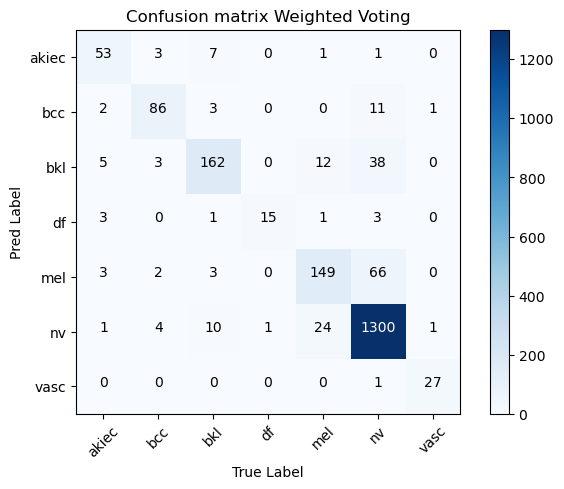

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix Weighted Voting',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = targetnames) 
plt.xlabel('True Label')
plt.ylabel('Pred Label')

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(ensemble_predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob=ensemble_predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report DenseNet201+SA:")
print(report)


Classification Report DenseNet201+SA:
              precision    recall  f1-score   support

       akiec       0.79      0.82      0.80        65
         bcc       0.88      0.83      0.86       103
         bkl       0.87      0.74      0.80       220
          df       0.94      0.65      0.77        23
         mel       0.80      0.67      0.73       223
          nv       0.92      0.97      0.94      1341
        vasc       0.93      0.96      0.95        28

    accuracy                           0.89      2003
   macro avg       0.87      0.81      0.83      2003
weighted avg       0.89      0.89      0.89      2003



In [ ]:
print("Average = 'weighted'")
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))


Average = 'weighted'
Precision: 0.8918674900696395
Recall: 0.8946580129805292
Accuracy: 0.8946580129805292
Roc score: 0.9707528050115594


In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9963086449154561
The ROC AUC score of bcc is: 0.9921154828819622
The ROC AUC score of bkl is: 0.9685106816907154
The ROC AUC score of df is: 0.9829380764163373
The ROC AUC score of mel is: 0.9590542651282309
The ROC AUC score of nv is: 0.9693751112372739
The ROC AUC score of vasc is: 0.9996021699819169


Analyze


In [ ]:
import csv

sa_model = Model(model.inputs, model.get_layer('soft_attention').output)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Open a CSV file for writing
with open('output.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    csvwriter = csv.writer(csvfile)

    # Write header row
    csvwriter.writerow(['id', 'pred', 'gt'])

    for i in range(len(test_batches)):
        x_test, y_test = test_batches[i]
        sa_features, sa_maps = sa_model.predict(x_test)
        for j in range(len(x_test)):
            img_idx = j
            class_predictions = model.predict(x_test)

            prediction_index = np.argmax(class_predictions[j])
            ground_truth_index = np.argmax(y_test[j])
            pred = target_names[prediction_index]
            gt = target_names[ground_truth_index]

            # Write row to CSV
            csvwriter.writerow([f"{i}_{j}", pred, gt])


In [ ]:
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


for i in range(len(test_batches)):
    x_test,y_test=test_batches[i]
    sa_features, sa_maps = sa_model.predict(x_test)
    for j in range(len(x_test)):
        img_idx = j
        t = (x_test + 1)/2 
        fig, axes = plt.subplots(2, 1)
        axes[0].imshow(t[img_idx])
        class_predictions = model.predict(x_test)

        prediction_index = np.argmax(class_predictions[j])
        ground_truth_index = np.argmax(y_test[j])
        pred = target_names[prediction_index]
        gt = target_names[ground_truth_index]
        
        sum_attnmap = np.sum(sa_maps[img_idx],0)
        axes[1].imshow(t[img_idx],alpha=1.0)
        axes[1].imshow(cv2.resize(sum_attnmap,(224,224),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.5)
        axes[1].set_xlabel(f"Pred: {pred}, Gt: {gt}")
        
        if (pred == gt):
            plt.savefig('trueCases/plt_' + str(i) + '_' + str(j) + '.jpg')
        else: 
            plt.savefig('failCases/plt_' + str(i) + '_' + str(j) + '.jpg')
